<a href="https://colab.research.google.com/github/Ebadi-Fereshteh/Deep-Learning/blob/main/49_DCGAN/Celeba/DCGAN_Celeba.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle
!ls -a ~/.kaggle
!kaggle datasets download -d jessicali9530/celeba-dataset

In [ ]:
!unzip celeba-dataset.zip

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2DTranspose, Conv2D, BatchNormalization, Flatten, LeakyReLU,ReLU, Reshape, Dropout
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from tqdm import tqdm
import time
from IPython import display
import PIL
import glob
import imageio
import random

In [ ]:
!rm celeba-dataset.zip

In [ ]:
#preprocess Data
images = [] # data
width = height = 64
for image_name in os.listdir("/content/img_align_celeba/img_align_celeba"):
  image = cv2.imread(f"/content/img_align_celeba/img_align_celeba/{image_name}")
  image = cv2.resize(image, (width, height))
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  images.append(image)

In [ ]:
images = np.array(images)
images.shape

(202599, 64, 64, 3)

In [ ]:
!rm -rf img_align_celeba
!rm list_bbox_celeba.csv
!rm list_eval_partition.csv
!rm list_landmarks_align_celeba.csv
!rm list_attr_celeba.csv

In [ ]:
images_part1 = images[0:50000,:,:,:]
images_part2 = images[50001:100000,:,:,:]
images_part3 = images[100001:150000,:,:,:]
images_part4 = images[150001:202599,:,:,:]
images=[]

In [ ]:
# Reshape data

train_data1 = images_part1.reshape(images_part1.shape[0], 64, 64, 3).astype('float32')
# Normalize the images to [-1, 1]
train_data1 = (train_data1 - 127.5)/ 127.5
# train_data2 = images_part2.reshape(images_part2.shape[0], 64, 64, 3).astype('float32')
# # Normalize the images to [-1, 1]
# train_data2 = (train_data2 - 127.5)/ 127.5
# train_data3 = images_part3.reshape(images_part3.shape[0], 64, 64, 3).astype('float32')
# # Normalize the images to [-1, 1]
# train_data3 = (train_data3 - 127.5)/ 127.5
# train_data4 = images_part4.reshape(images_part4.shape[0], 64, 64, 3).astype('float32')
# # Normalize the images to [-1, 1]
# train_data4 = (train_data4 - 127.5)/ 127.5
# images_part1 = []
# images_part2 = []
# images_part3 = []
# images_part4 = []

In [ ]:
train_data2 = images_part2.reshape(images_part2.shape[0], 64, 64, 3).astype('float32')
# Normalize the images to [-1, 1]
train_data2 = (train_data2 - 127.5)/ 127.5

In [ ]:
images_part1 = []
images_part2 = []
images_part3 = []
images_part4 = []

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [ ]:
# Batch and shuffle the data
train_batchData1 = tf.data.Dataset.from_tensor_slices(train_data1).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_batchData2 = tf.data.Dataset.from_tensor_slices(train_data2).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
# train_batchData3 = tf.data.Dataset.from_tensor_slices(train_data3).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
# train_batchData4 = tf.data.Dataset.from_tensor_slices(train_data4).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
train_data1 = []
train_data2 = []

##**Models**

In [ ]:
w =16
generator_model = tf.keras.Sequential([
        Dense(w*w*256, use_bias=False, input_shape=(100,)),
        BatchNormalization(),
        LeakyReLU(),
        Reshape((w, w, 256)),
        Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        BatchNormalization(),
        LeakyReLU(),
        Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias= False),
        BatchNormalization(),
        LeakyReLU(),
        Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias= False, activation='tanh')       

])
generator_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 65536)             6553600   
                                                                 
 batch_normalization (BatchN  (None, 65536)            262144    
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 65536)             0         
                                                                 
 reshape (Reshape)           (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 128)      819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 128)      5

In [ ]:
# Random noise generated before model training:
noise = tf.random.normal([1, 100])
generated_image = generator_model(noise, training=False)
plt.imshow(generated_image[0, :, :, 0])

In [ ]:
discriminator_model = tf.keras.Sequential([
    Conv2D(64, (5, 5), strides=(1, 1), padding='same', input_shape=[64, 64, 3]),
    LeakyReLU(),
    # Dropout(0.3),
    # Conv2D(64, (5, 5), strides=(2, 2), padding='same'),
    # LeakyReLU(),
    # Dropout(0.3),
    Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
    LeakyReLU(),
    Flatten(),
    Dropout(0.3),
    Dense(2)
])


In [ ]:
discriminator_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        4864      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 64, 64, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dropout (Dropout)           (None, 131072)            0         
                                                                 
 dense_1 (Dense)             (None, 2)                

In [ ]:
# Decision result before model training:
decision = discriminator_model(generated_image)
print(np.argmax(decision))

1


## **Loss Function**

In [ ]:
loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

In [ ]:
def generator_Loss(fake_output):
  return loss_function(tf.ones_like(fake_output), fake_output)

In [ ]:
def discriminator_loss(real_output, fake_output):
  real_loss = loss_function(tf.ones_like(real_output), real_output),
  fake_loss = loss_function(tf.zeros_like(fake_output), fake_output),
  total_loss = (real_loss + fake_loss) 
  return total_loss

##**Optimizer**

In [ ]:
LR = 0.0002
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=LR, beta_1= 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=LR, beta_1=0.5)

##**Save weights**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
checkpoint_dir = '/content/drive/MyDrive/models/DCGAN/Celeba/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer= generator_optimizer,
              generator=generator_model,
              discriminator_optimizer=discriminator_optimizer,
              discriminator=discriminator_model)

##**Hyper parameters**

In [ ]:
EPOCHS = 100
noise_dim = 100
num_example_to_generate = 16
seed = tf.random.normal([num_example_to_generate, noise_dim])

##**Train**

In [ ]:
@tf.function
def train_step(real_images):
  noise = tf.random.normal([BATCH_SIZE, noise_dim])
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator_model(noise, training=True)
    real_output = discriminator_model(real_images, training=True)
    fake_output = discriminator_model(generated_images, training=True)
    
    gen_loss = generator_Loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_genarator = gen_tape.gradient(gen_loss, generator_model.trainable_variables) 
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator_model.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_genarator, generator_model.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator_model.trainable_variables))



In [ ]:
def train(dataset1, dataset2, epochs):
  for epoch in range(epochs):
    start = time.time()
    for image_batch in tqdm(dataset1):
      train_step(image_batch)
    for image_batch in tqdm(dataset2):
      train_step(image_batch)
    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator_model, epoch+ 1, seed)

    # Save the model every 15 epochs
    if(epoch+ 1) % 15==0:
      checkpoint.save(file_prefix= checkpoint_prefix)
    
    print ('Time for epoch {} is {} sec'.format(epoch +1, time.time()- start))
    
  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator_model, epochs, seed)


In [ ]:
def generate_and_save_images(model, epoch, test_images):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_images, training=False)

  fig = plt.figure(figsize=(8, 8))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow((np.array(predictions[i, :, :, :] * 127.5 ) + 127.5 ).astype('uint8'))
    plt.axis('off')
    
  plt.savefig('/content/drive/MyDrive/models/DCGAN/Celeba/images/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


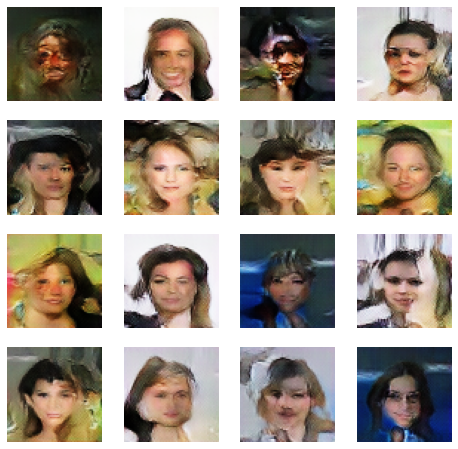

Time for epoch 86 is 267.3568651676178 sec


 96%|█████████▌| 750/782 [02:07<00:05,  6.25it/s]

In [ ]:
train(train_batchData1, train_batchData2, EPOCHS)

In [ ]:
#Restore the latest checkpoint.
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('/content/drive/MyDrive/models/DCGAN/Celeba/images/image_at_epoch_{:04d}.png'.format(epoch_no))

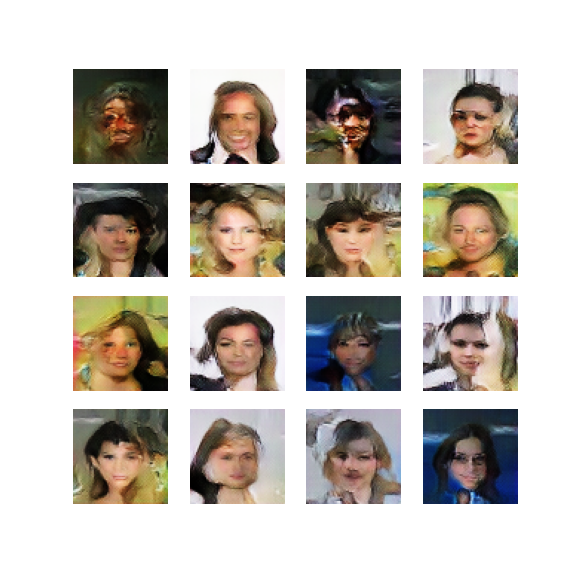

In [ ]:
display_image(86)

In [ ]:
# Use imageio to create an animated gif using the images saved during training.
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('/content/drive/MyDrive/models/DCGAN/Celeba/images/image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
!pip install git+https://github.com/tensorflow/docs

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)